In [1]:
import BioSimSpace as BSS
import pipeline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pipeline.analysis import analyse

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest 


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



In [2]:
def truncation_check(path_to_dir, estimator):

    # analyse the work dir
    analysed_pert = analyse(path_to_dir)

    truncate_percentage = [5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100]
    
    results_dict = {}
    bound_dict = {}
    free_dict = {}

    for trunc_per in truncate_percentage:

        analysed_pert.set_options({ "estimator" : estimator,
                                    "truncate percentage": trunc_per,
                                    "try pickle": True,
                                    "truncate keep":"start"})

        analysed_pert.analyse_all_repeats()

        # save output in the pickle dir 
        # write_analysis_file(analysed_pert, analysed_pert._pickle_dir, method=trunc_per)

        results_dict[trunc_per] = (analysed_pert.freenrg_val, analysed_pert.freenrg_err)
        bound_dict[trunc_per] = (analysed_pert.bound_val, analysed_pert.bound_err)
        free_dict[trunc_per] = (analysed_pert.free_val, analysed_pert.free_err)

    return results_dict, bound_dict, free_dict

def for_folder(main_dir, network_file, estimator):
    # check all the perturbations in the network
    perts, ligs = pipeline.analysis._network.get_info_network(net_file=network_file)

    engines = pipeline.utils.validate.engines()

    for engine in engines:

        pert_results_dict = {}
        pert_bound_dict = {}
        pert_free_dict = {}

        for pert in perts:
            # find the extract folder
            # find correct path, use extracted if it exists
            if os.path.exists(f"{main_dir}/outputs_extracted/{engine}/{pert}"):
                path_to_dir = f"{main_dir}/outputs_extracted/{engine}/{pert}"
                final_results_folder = f"{main_dir}/outputs_extracted/results"
            elif os.path.exists(f"{main_dir}/outputs/{engine}_extracted/{pert}"):
                path_to_dir = f"{main_dir}/outputs/{engine}_extracted/{pert}"
                final_results_folder = f"{main_dir}/outputs/results"
            else:
                path_to_dir = f"{main_dir}/outputs/{engine}/{pert}"
                final_results_folder = f"{main_dir}/outputs/results"

            # calculate all the truncated data
            results_dict, bound_dict, free_dict = truncation_check(path_to_dir, estimator)

            pert_results_dict[pert] = results_dict
            pert_bound_dict[pert] = bound_dict
            pert_free_dict[pert] = free_dict
    
    return pert_results_dict, pert_bound_dict, pert_free_dict

In [6]:
mf = "/home/anna/Documents/benchmark/extracted/tyk2"
net_file = f"{mf}/execution_model/network_lomap.dat"
results_dict, bound_dict, free_dict = for_folder(mf,
                                                 net_file,
                                                 "MBAR")

perts, ligs = pipeline.analysis._network.get_info_network(net_file=net_file)

There are 3 repeats for each the bound and the free for /home/anna/Documents/benchmark/extracted/tyk2/outputs_extracted/AMBER/lig_ejm42~lig_ejm49.these are ['bound_0', 'bound_1', 'bound_2'] and ['free_0', 'free_1', 'free_2'].
trying to locate pickles in default pickle folder, /home/anna/Documents/benchmark/extracted/tyk2/outputs_extracted/AMBER/lig_ejm42~lig_ejm49/pickle for lig_ejm42~lig_ejm49_AMBER_MBAR_alchemlyb_None_eqfalse_statsfalse_truncate5start...
pickles found!
the number of calculated values for bound does not match the number of bound folders.
 maybe try reanalysing/check errors?
the number of calculated values for free does not match the number of free folders.
 maybe try reanalysing/check errors?
There are 0 calculated values for each the bound and the free leg for the folders in /home/anna/Documents/benchmark/extracted/tyk2/outputs_extracted/AMBER/lig_ejm42~lig_ejm49.
'0_bound'
could not check overlap matrix for 0_bound
'1_bound'
could not check overlap matrix for 1_boun

In [17]:
pert_dict = results_dict['lig_ejm42~lig_ejm49']

def single_pert_dict_into_df(pert_dict):

    df = pd.DataFrame.from_dict(pert_dict)
    df = df.transpose()
    df.columns = ["avg","max"]
    df["min"] = df.loc[:, "max"]*-1
    
    return df

sdf = single_pert_dict_into_df(pert_dict)
sdf['avg'].iloc[-1]+sdf['min'].iloc[-1]
sdf['avg'].iloc[-1]+sdf['max'].iloc[-1]

-1.4917339844549597

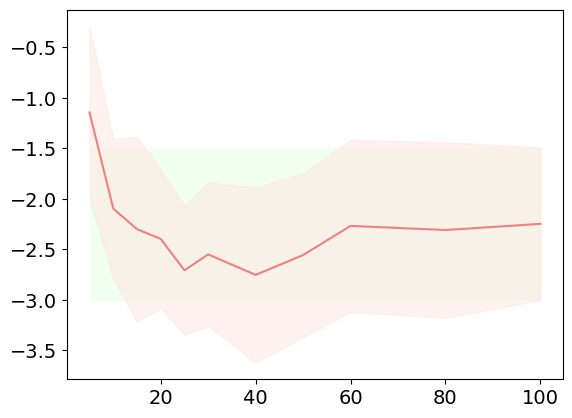

In [22]:
plt.fill_between(sdf.index, sdf['avg'].iloc[-1]+sdf['min'].iloc[-1], sdf['avg'].iloc[-1]+sdf['max'].iloc[-1],  color="honeydew", alpha=1)
scatterplot = [plt.plot(sdf.index, sdf['avg'], c="lightcoral")]
plt.fill_between(sdf.index, sdf['avg']+sdf['min'], sdf['avg']+sdf['max'], color="mistyrose", alpha=.5)
# lines += plt.plot(0,0,c="lightcoral", label="forward")
# scatterplot = [plt.plot(edf.index, edf['avg'], c="cornflowerblue")]
# plt.fill_between(edf.index, edf['avg']+edf['min'], edf['avg']+edf['max'], color="lightskyblue", alpha=.3)
# lines += plt.plot(0,0,c="cornflowerblue", label="reverse")

In [13]:

def plot_truncated(pert_dict, file_path=None, plot_error=False, plot_difference=True):

    df = pd.DataFrame.from_dict(pert_dict)
    perts = list(df.columns)
    df = df.reset_index().dropna()
    if file_path:
        df.to_csv(f"{file_path.replace('.png','.csv')}")

    # include_key = False

    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(10,10))

    index_dict = {}
    for x in df['index']:
        index_dict[x] = []

    for pert in perts:
        x_vals = []
        y_vals = []
        lines = []
        for a,x in zip(df[pert], df['index']):
            if plot_error:
                ind = 1
            else:
                ind = 0
            if plot_difference:
                y_val = (df.iloc[-1][pert][ind] - a[ind])
            else:
                y_val = a[ind]
            if not index_dict[x]:
                index_dict[x] = [y_val]
            else:
                index_dict[x].append(y_val)
            y_vals.append(y_val)
            x_vals.append(x)

    for x in df['index']:
        val_list = [x for x in index_dict[x] if pd.notna(x)]
        avg = np.mean(val_list)
        min_val = min(val_list)
        max_val = max(val_list)

        index_dict[x] = (avg, min_val, max_val)

    df = pd.DataFrame.from_dict(index_dict, orient="index", columns=["avg","min","max"])

    scatterplot = plt.plot(df.index, df['avg'], c="lightcoral")
    plt.fill_between(df.index, df['min'], df['max'], color="mistyrose", alpha=.5)

    # if include_key:
    #     labels = [l.get_label() for l in lines]
    #     plt.legend(lines, labels, loc='upper left')
    
    plt.xlabel('Percentage of run used (from start)')
    if file_path:
        plt.title(f"{file_path.split('/')[-1].split('.')[0].replace('_',' ')}")
    else:
        pass

    if plot_error:
        if plot_difference:
            plt.ylabel("Computed Error difference to final / kcal$\cdot$mol$^{-1}$")
        else:
            plt.ylabel("Computed Error / kcal$\cdot$mol$^{-1}$")
    else:
        if plot_difference:
            plt.ylabel("difference to final result for computed $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
        else:
            plt.ylabel("Computed $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

    if file_path:
        plt.savefig(file_path)

In [78]:

def plot_truncated(pert_dict, file_path=None, plot_error=False, plot_difference=False, plot_diff="end"):

    df = pd.DataFrame.from_dict(pert_dict)
    perts = list(df.columns)
    df = df.reset_index().dropna()
    if file_path:
        df.to_csv(f"{file_path.replace('.png','.csv')}")

    include_key = False

    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(10,10))

    index_dict = {}
    for x in df['index']:
        index_dict[x] = []

    for pert in perts:
        x_vals = []
        y_vals = []
        lines = []
        for a,x in zip(df[pert], df['index']):
            y_val = (df.iloc[-1][pert][0] - a[0])
            if not index_dict[x]:
                index_dict[x] = [y_val]
            else:
                index_dict[x].append(y_val)
            y_vals.append(y_val)
            x_vals.append(x)

    for x in df['index']:
        val_list = [x for x in index_dict[x] if pd.notna(x)]
        avg = np.mean(val_list)
        min_val = min(val_list)
        max_val = max(val_list)

        index_dict[x] = (avg, min_val, max_val)

    df = pd.DataFrame.from_dict(index_dict, orient="index", columns=["avg","min","max"])

    scatterplot = plt.plot(df.index, df['avg'], c="lightcoral")
    plt.fill_between(df.index, df['min'], df['max'], color="mistyrose", alpha=.5)

    if include_key:
        labels = [l.get_label() for l in lines]
        plt.legend(lines, labels, loc='upper left')
    
    plt.xlabel('Percentage of run used (from start)')
    # plt.title(f"{file_path.split('/')[-1].split('.')[0].replace('_',' ')}")

    if plot_error:
        if plot_difference:
            plt.ylabel("Computed Error difference to final / kcal$\cdot$mol$^{-1}$")
        else:
            plt.ylabel("Computed Error / kcal$\cdot$mol$^{-1}$")
    else:
        if plot_difference:
            plt.ylabel("difference to final result for computed $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
        else:
            plt.ylabel("Computed $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

    if file_path:
        plt.savefig(file_path)